In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### разобьем данные на две части


In [ ]:
#wine = pd.read_csv('wineQualityWhites.csv', index_col = 'Unnamed: 0')
#wine[:500].to_csv('test_wine.csv', index=False)
#wine[500:].to_csv('train_wine.csv', index=False)

### загрузим часть, оставленную на обучение

In [42]:
wine_train = pd.read_csv('train_wine.csv' )
wine_train.head(3)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.2,0.28,0.54,16.70,0.045,54.0,200.0,0.9990,3.08,0.49,9.5,6
1,6.8,0.19,0.58,14.20,0.038,51.0,164.0,0.9975,3.12,0.48,9.6,6
2,6.4,0.30,0.30,2.25,0.038,8.0,210.0,0.9937,3.20,0.62,9.9,6


#### немножечко препроцессинг

In [43]:
wine_train['quality'] = wine_train['quality'].apply(lambda x: 1 if (x > 6 ) else 0)
display(wine_train.quality.unique())
#data = wine_train.iloc[:,:-1].values
#target = wine_train.iloc[:,-1].values

array([0, 1], dtype=int64)

# Блок обучения / отбора

### RandomForestClassifier

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from tqdm import tqdm

бейслайн для случайного леса

In [19]:

data = wine_train.iloc[:,:-1]
target = wine_train.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

rf = RandomForestClassifier(n_estimators = 20, random_state=42, n_jobs=-1) #
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)



print('Правильность на обучающем наборе: {:.3f}'.format(rf.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(rf.score(X_test, y_test)))
print('Точность на обучающем наборе: {:.3f}'.format(precision_score(y_test, y_pred)))

Правильность на обучающем наборе: 0.998
Правильность на тестовом наборе: 0.869
Точность на обучающем наборе: 0.796



100%|██████████| 100/100 [02:41<00:00,  2.80s/it]

Best accuracy is 0.875% with 44 trees


Text(0.5, 0, 'N_estimators')

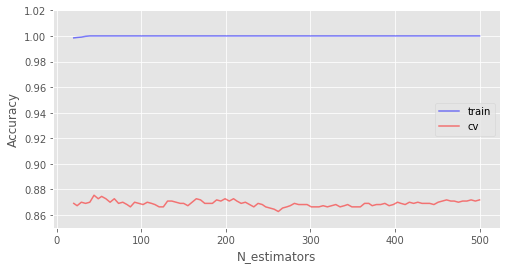

In [20]:
# деревья
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

train_acc = []
test_acc = []


trees_grid = [int(x) for x in np.linspace(start = 20, stop = 500, num = 100)]

for ntrees in tqdm(trees_grid):
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
train_acc, test_acc  = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.3f}% with {} trees".format(max(test_acc), 
                                                        trees_grid[np.argmax(test_acc)]))


plt.style.use('ggplot')
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.85,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

#### зафиксировала количество деревьев на 44, теперь подберем глубину

In [25]:
train_acc = []
test_acc = []

max_depth_grid = [int(x) for x in np.linspace(10, 110, num = 100)]

for max_depth in tqdm(max_depth_grid):
    rfc = RandomForestClassifier(n_estimators=44, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc), 
                                                        max_depth_grid[np.argmax(test_acc)]))


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]

Best accuracy on CV is 0.88% with 23 max_depth



100%|██████████| 12/12 [00:06<00:00,  1.78it/s]

Best accuracy on CV is 0.88% with 1 min_samples_leaf


Text(0.5, 0, 'Min_samples_leaf')

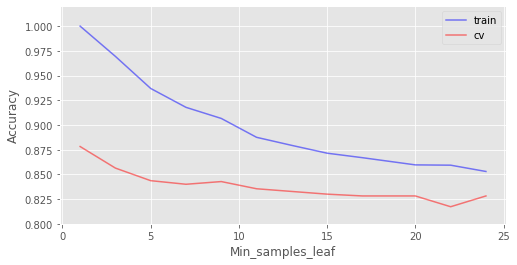

In [26]:
train_acc = []
test_acc = []

min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in tqdm(min_samples_leaf_grid):
    rfc = RandomForestClassifier(n_estimators=44, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf, max_depth = 23)
    
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
 
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.2f}% with {} min_samples_leaf".format(max(test_acc), 
                                                        min_samples_leaf_grid[np.argmax(test_acc)]))



fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.80,1.02])

ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")


100%|██████████| 11/11 [00:06<00:00,  1.52it/s]

Best accuracy is 0.878182% with 3 max_features


Text(0.5, 0, 'Max_features')

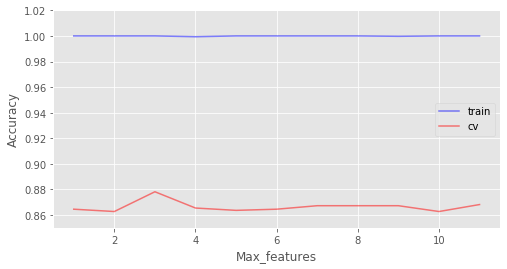

In [27]:
train_acc = []
test_acc = []

max_features_grid = [int(x) for x in np.linspace(1, 11, num = 11)]
for max_features in tqdm(max_features_grid):
    rfc = RandomForestClassifier(n_estimators=44, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features, max_depth = 23)
    rfc.fit(X_train, y_train)
    
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.6f}% with {} max_features".format(max(test_acc), 
                                                        max_features_grid[np.argmax(test_acc)]))


fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.85,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

In [ ]:
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

rfc = RandomForestClassifier(n_estimators=44, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=3, max_depth = 23)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
precision_score(y_test, y_pred)

### GradientBoostingClassifier

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

gbrt = GradientBoostingClassifier(random_state=0, max_depth=10) 
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

print('Правильность на обучающем наборе: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gbrt.score(X_test, y_test)))
print('Точность на обучающем наборе: {:.3f}'.format(precision_score(y_test, y_pred)))

Правильность на обучающем наборе: 1.000
Правильность на тестовом наборе: 0.860
Точность на обучающем наборе: 0.724


подбираю количество деревьев 

In [8]:
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

train_acc = []
test_acc = []

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 3000, num = 100)]

for i in tqdm(n_estimators):
    gb = GradientBoostingClassifier(random_state=42, n_estimators=i) 
    gb.fit(X_train, y_train)
    
    train_acc.append(gb.score(X_train, y_train))
    test_acc.append(gb.score(X_test, y_test))
    
train_acc, test_acc  = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.4f}% with {} n_estimators".format(max(test_acc), 
                                                        n_estimators[np.argmax(test_acc)]))

100%|██████████| 100/100 [08:11<00:00, 13.10s/it]


Best accuracy on CV is 0.8718% with 735 n_estimators


Text(0.5, 0, 'N_estimators')

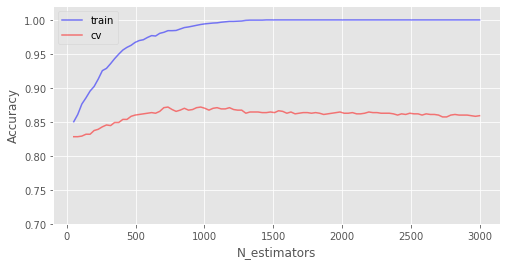

In [9]:
plt.style.use('ggplot')
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(n_estimators, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(n_estimators, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

видим, что пики приходятся между 700 и 1000, посмотрим детальнее

100%|██████████| 30/30 [01:52<00:00,  4.32s/it]


Best accuracy on CV is 0.8727% with 979 n_estimators


Text(0.5, 0, 'N_estimators')

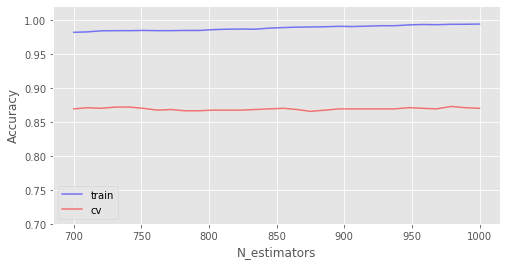

In [10]:
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

train_acc = []
test_acc = []

n_estimators = [int(x) for x in np.linspace(start = 700, stop = 1000, num = 30)]

for i in tqdm(n_estimators):
    gb = GradientBoostingClassifier(random_state=42, n_estimators=i) 
    gb.fit(X_train, y_train)
    
    train_acc.append(gb.score(X_train, y_train))
    test_acc.append(gb.score(X_test, y_test))
    
train_acc, test_acc  = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.4f}% with {} n_estimators".format(max(test_acc), 
                                                        n_estimators[np.argmax(test_acc)]))

plt.style.use('ggplot')
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(n_estimators, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(n_estimators, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

зафиксируем количество деревьев на 979, подбираю max_depth


100%|██████████| 25/25 [02:21<00:00,  5.09s/it]

Best accuracy is 0.8727% with 3 max_depth


Text(0.5, 0, 'max_depth')

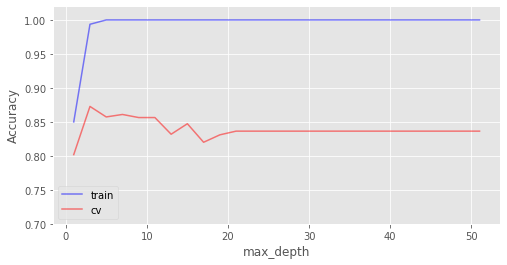

In [12]:
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

train_acc = []
test_acc = []


max_depth = [int(x) for x in np.linspace(start = 1, stop = 51, num = 25)]

for i in tqdm(max_depth):
    gb = GradientBoostingClassifier(n_estimators =979, random_state=42, max_depth=i) 
    gb.fit(X_train, y_train)
    
    train_acc.append(gb.score(X_train, y_train))
    test_acc.append(gb.score(X_test, y_test))
    
train_acc, test_acc  = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.4f}% with {} max_depth".format(max(test_acc), 
                                                        max_depth[np.argmax(test_acc)]))


plt.style.use('ggplot')
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(max_depth, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("max_depth")

подбираю learning_rate


100%|██████████| 10/10 [00:40<00:00,  3.76s/it]

Best accuracy is 0.8727% with 0.1 learning_rate


Text(0.5, 0, 'learning_rate')

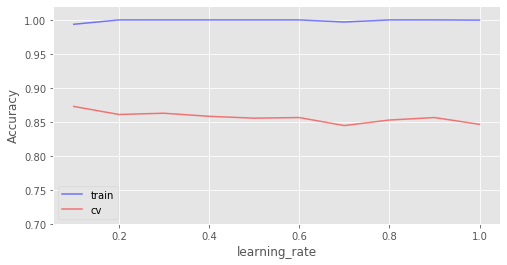

In [13]:
#learning_rate

train_acc = []
test_acc = []


learning_rate = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for i in tqdm(learning_rate):
    gb = GradientBoostingClassifier(n_estimators = 979, random_state=42,  max_depth=3, learning_rate=i) 
    gb.fit(X_train, y_train)
    
    train_acc.append(gb.score(X_train, y_train))
    test_acc.append(gb.score(X_test, y_test))
    
train_acc, test_acc  = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy is {:.4f}% with {} learning_rate".format(max(test_acc), 
                                                        learning_rate[np.argmax(test_acc)]))


plt.style.use('ggplot')
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(learning_rate, train_acc, alpha=0.5, color='blue', label='train')
ax.plot(learning_rate, test_acc, alpha=0.5, color='red', label='cv')
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("learning_rate")


# Блок моделей

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.metrics import precision_score

In [45]:
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

gb = GradientBoostingClassifier(n_estimators = 979, random_state=42,  max_depth=3, learning_rate=0.1) 
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

print('Правильность на обучающем наборе: {:.3f}'.format(gb.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gb.score(X_test, y_test)))
print('Точность на тестовом наборе: {:.3f}'.format(precision_score(y_test, y_pred)))

Правильность на обучающем наборе: 0.994
Правильность на тестовом наборе: 0.873
Точность на тестовом наборе: 0.772


In [46]:
data = wine_train.iloc[:,:-1].values
target = wine_train.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

rf = RandomForestClassifier(n_estimators=44, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=3, max_depth = 23)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Правильность на обучающем наборе: {:.3f}'.format(gb.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.3f}'.format(gb.score(X_test, y_test)))
print('Точность на тестовом наборе: {:.3f}'.format(precision_score(y_test, y_pred)))

Правильность на обучающем наборе: 0.994
Правильность на тестовом наборе: 0.873
Точность на тестовом наборе: 0.827


# Блок для проверки 

In [47]:
wine_test = pd.read_csv('test_wine.csv')
wine_test['quality'] = wine_test['quality'].apply(lambda x: 1 if (x > 6 ) else 0)
data = wine_test.iloc[:,:-1].values
target = wine_test.iloc[:,-1].values

y_pred = gb.predict(data)
precision_score(target, y_pred)

print('Точность на тестовом наборе: {:.2f}'.format(precision_score(target, y_pred)))

Точность на тестовом наборе: 0.70


In [48]:
wine_test = pd.read_csv('test_wine.csv')
wine_test['quality'] = wine_test['quality'].apply(lambda x: 1 if (x > 6 ) else 0)
data = wine_test.iloc[:,:-1].values
target = wine_test.iloc[:,-1].values

y_pred = rf.predict(data)
precision_score(target, y_pred)

print('Точность на тестовом наборе: {:.2f}'.format(precision_score(target, y_pred)))

Точность на тестовом наборе: 0.84
